In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
from datetime import datetime

# Set Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'mediter'
os.environ['KAGGLE_KEY'] = 'fc587ce858b120231079eb32ee263481'

# Initialize Kaggle API
api = KaggleApi()
api.authenticate()

In [2]:
# List to store dataset information
datasets_info = []

# Use pagination to get a sufficient number of datasets from Kaggle
page_number = 1
while len(datasets_info) < 200:
    recent_datasets = api.datasets_list(sort_by='votes', page=page_number)
    for dataset in recent_datasets:
        dataset_info = {
            'name': dataset.get('title', 'N/A'),
            'id': dataset.get('id', 'N/A'),
            'description': dataset.get('description', 'N/A'),
            'tags': ', '.join(dataset.get('keywords', [])),
            'views': dataset.get('viewCount', 0),
            'upvotes': dataset.get('voteCount', 0),
            'filesize': dataset.get('size', 0),
            'uploadtime': dataset.get('createdDate', ''),
            'author': dataset.get('ownerName', ''),
            'license': ', '.join([license['name'] for license in dataset.get('licenses', [])]) if dataset.get('licenses') else 'N/A',
            'file_types': ', '.join(dataset.get('fileTypes', []))
        }
        # Remove fields with empty, N/A, or 0 values
        dataset_info = {k: v for k, v in dataset_info.items() if v not in ('', 'N/A', 0)}
        datasets_info.append(dataset_info)
    page_number += 1

The data comes from Kaggle, a popular platform for data science competitions and dataset sharing. Using Kaggle's API, the script gathers various details about datasets, such as the dataset name, ID, description, tags, view count, upvotes, file size, upload time, author, and license type. During the data collection process, the script first authenticates the API and then uses pagination to retrieve dataset information from Kaggle platform pages. For each dataset, the script pulls and cleans the relevant fields, removing any empty or unnecessary values, and stores the valid data in a list. In this way, the script keeps scraping multiple pages to ensure that a total of 200 datasets are collected.

In [4]:
# Convert dataset information to a Pandas DataFrame
df = pd.DataFrame(datasets_info)

# If there are more than 200 records, limit to the top 200 by upvotes
if len(df) > 200:
    df = df.nlargest(200, 'upvotes')

In [5]:
# 2. Popularity (weighted score)
# Create a weighted score using views and upvotes
if 'views' in df.columns and 'upvotes' in df.columns:
    df['popularity_score'] = 0.6 * df['views'] + 0.4 * df['upvotes']  # Calculate popularity score
    df['popularity_score'] = df['popularity_score'].round()  # Round the popularity score

1. Data Cleaning:
Removing Unnecessary Data:
After extracting fields from each dataset, the code removes any fields with empty values, "N/A", or 0, ensuring that only meaningful data is kept. This is done using a method that filters out unnecessary fields.
Handling Missing Data:
The code checks for empty strings, "N/A", or 0 values and avoids adding them to the final dataset, ensuring the data is valid.
2. Feature Extraction:
Creating Popularity Score:A new feature called popularity_score is created by combining the views (number of times seen) and upvotes (number of likes) fields. The score is calculated by giving 60% weight to views and 40% weight to upvotes, showing how popular the dataset is.
Rounding the Score:The calculated score is rounded to make it simpler and easier to use.
4. Data Aggregation:
Limiting the Number of Datasets:
If there are more than 200 datasets, the code sorts them by upvotes and keeps only the top 200 datasets with the most upvotes. This makes sure that the analysis focuses on the most popular datasets.

Summary statistics:
                 id         views       upvotes  popularity_score
count  2.000000e+02  2.000000e+02    200.000000      2.000000e+02
mean   5.041302e+05  7.854552e+05   2128.490000      4.721245e+05
std    8.859350e+05  9.706314e+05   3654.559384      5.829045e+05
min    9.000000e+00  5.146000e+03    778.000000      3.538000e+03
25%    1.916250e+03  3.744308e+05   1020.500000      2.251742e+05
50%    3.052800e+04  5.466155e+05   1350.500000      3.284375e+05
75%    6.007628e+05  9.189342e+05   2209.750000      5.521140e+05
max    5.630996e+06  1.136689e+07  48643.000000      6.824820e+06


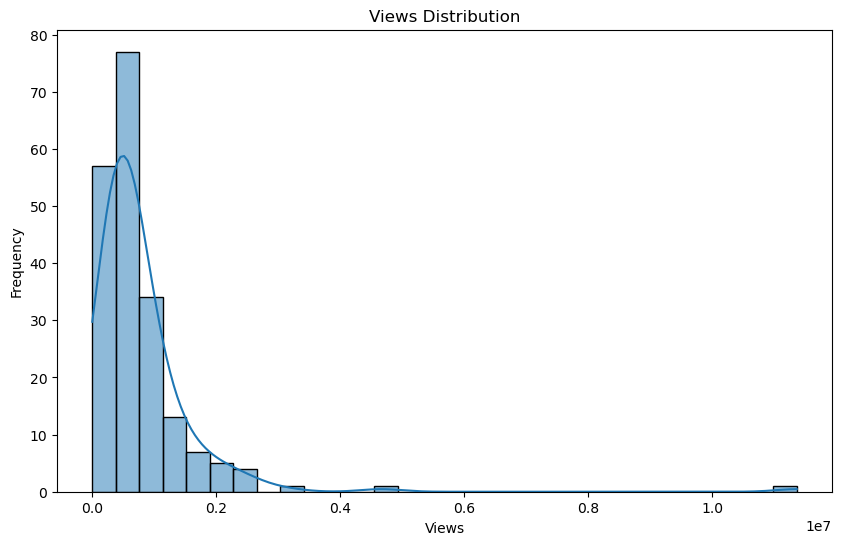

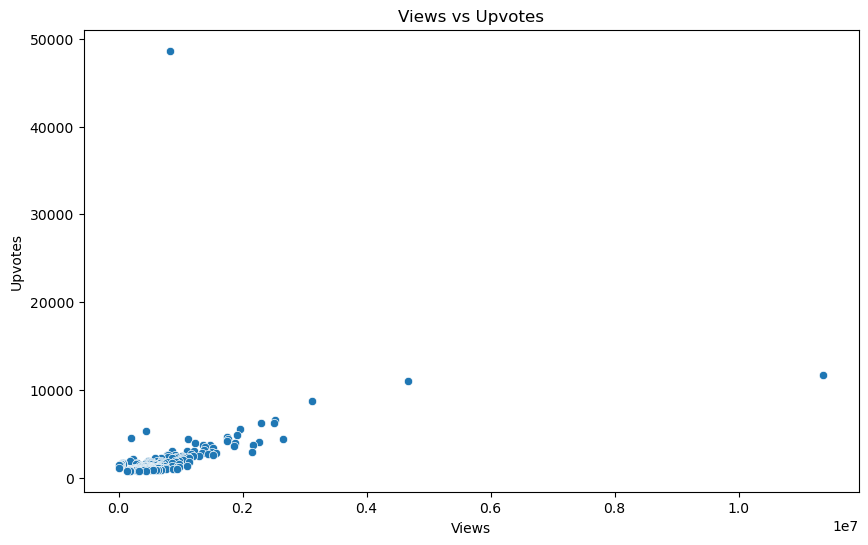

In [11]:
# 1. Calculate summary statistics
print("Summary statistics:")
print(df.describe())

# 2. Visualize the distribution
if 'views' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['views'], kde=True, bins=30)
    plt.title('Views Distribution')
    plt.xlabel('Views')
    plt.ylabel('Frequency')
    plt.show()

# 3. Explore the relationship between columns
if 'views' in df.columns and 'upvotes' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='views', y='upvotes', data=df)
    plt.title('Views vs Upvotes')
    plt.xlabel('Views')
    plt.ylabel('Upvotes')
    plt.show()

In [14]:
# Save the data to a CSV file
output_file = 'top_200_datasets_info_with_scores.csv'
df.to_csv(output_file, index=False)
print(f'Extracted {len(df)} dataset records and saved to file: {output_file}')

Extracted 200 dataset records and saved to file: top_200_datasets_info_with_scores.csv


According to the histogram obtained, the number of views of most data sets is mainly concentrated between 0.0 and 0.1, and the corresponding data sets are less and less as the number of views increases. From the scatter plot, the number of views and the number of likes is roughly positive correlation.

Main Question:
Is there a significant relationship between the number of views, the number of upvotes, and the dataset's publication date (with ID size representing the publication date)?

Sub-questions:
1.Is there a correlation between the views and upvotes of the datasets? If so, how does the correlation change (for example, does an increase in views lead to an increase in upvotes)?
2.Do "older" datasets (those with smaller IDs) tend to have lower views and upvotes? Alternatively, do older datasets gain more views and upvotes due to historical accumulation?
3.Can the publication date of a dataset (represented by the ID size) be used to predict its views and upvotes?

1.Is there a correlation between the views and upvotes of the datasets? If so, how does the correlation change (for example, does an increase in views lead to an increase in upvotes)?

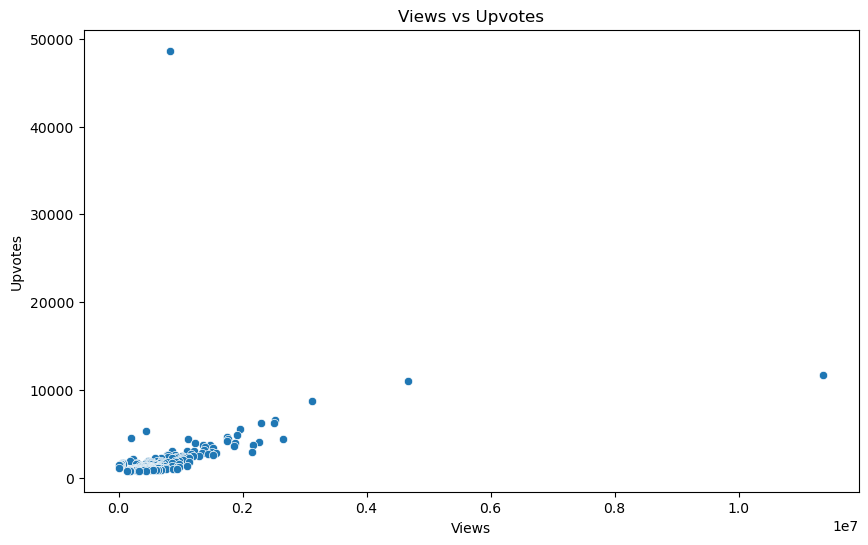

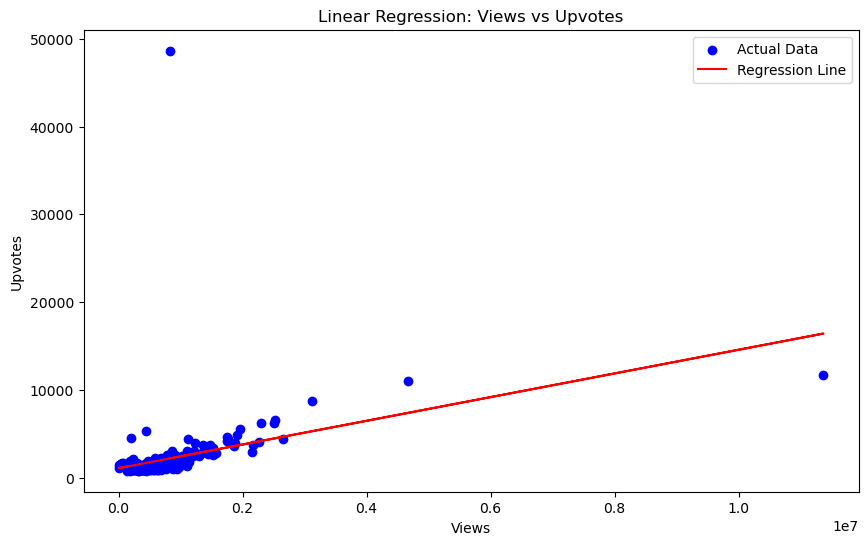

Regression model coefficients: [0.0013498]
Regression model intercept: 1068.2796095670972


In [19]:
from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Plot the scatter plot of views vs upvotes
if 'views' in df.columns and 'upvotes' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='views', y='upvotes', data=df)
    plt.title('Views vs Upvotes')
    plt.xlabel('Views')
    plt.ylabel('Upvotes')
    plt.show()

    # 2. Use linear regression to model the relationship between views and upvotes
    X = df[['views']].dropna()  # Views as the independent variable
    y = df['upvotes'].dropna()  # Upvotes as the dependent variable
    
    # Linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predicted values
    y_pred = model.predict(X)
    
    # Plot the regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='blue', label='Actual Data')
    plt.plot(X, y_pred, color='red', label='Regression Line')
    plt.title('Linear Regression: Views vs Upvotes')
    plt.xlabel('Views')
    plt.ylabel('Upvotes')
    plt.legend()
    plt.show()
    
    # 3. Output the coefficients and intercept of the regression model
    print("Regression model coefficients:", model.coef_)
    print("Regression model intercept:", model.intercept_)

There is a positive correlation between the number of views and the number of votes in the dataset, and an increase in the number of views leads to an increase in the number of votes.

2.Do "older" datasets (those with smaller IDs) tend to have lower views and upvotes? Alternatively, do older datasets gain more views and upvotes due to historical accumulation?
3.Can the publication date of a dataset (represented by the ID size) be used to predict its views and upvotes?

Correlation between Views and Upvotes:
             views   upvotes
views    1.000000  0.358501
upvotes  0.358501  1.000000
Old datasets (ID < median) average views: 934506.91
Old datasets (ID < median) average upvotes: 1931.97
New datasets (ID >= median) average views: 636403.4
New datasets (ID >= median) average upvotes: 2325.01
Views regression coefficient: [-0.23754778]
Upvotes regression coefficient: [-0.00015551]


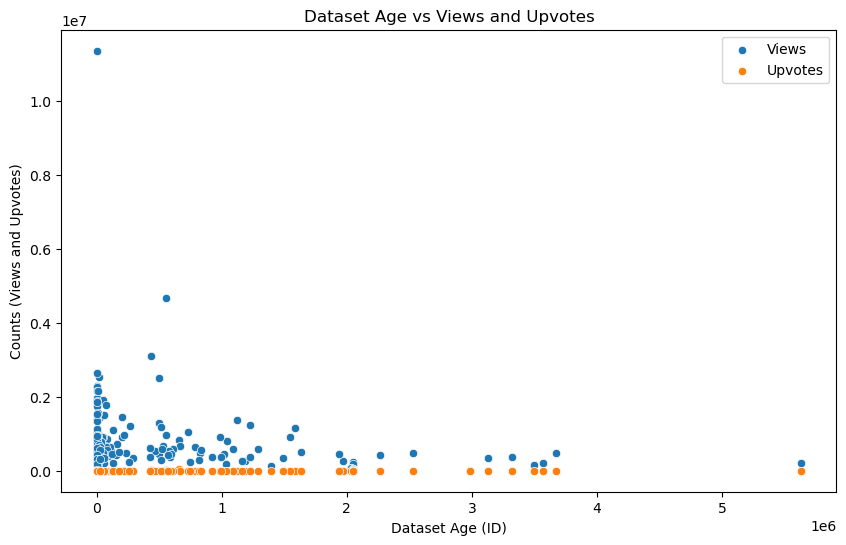

In [23]:
# Correlation analysis
correlation = df[['views', 'upvotes']].corr()
print("Correlation between Views and Upvotes:\n", correlation)

# Analyze the relationship between dataset ID and views/upvotes
df['dataset_age'] = df['id']  # Assume that smaller IDs represent older datasets
old_datasets = df[df['dataset_age'] < df['dataset_age'].median()]
new_datasets = df[df['dataset_age'] >= df['dataset_age'].median()]

print(f"Old datasets (ID < median) average views: {old_datasets['views'].mean()}")
print(f"Old datasets (ID < median) average upvotes: {old_datasets['upvotes'].mean()}")
print(f"New datasets (ID >= median) average views: {new_datasets['views'].mean()}")
print(f"New datasets (ID >= median) average upvotes: {new_datasets['upvotes'].mean()}")

# Linear regression analysis
from sklearn.linear_model import LinearRegression

# Set features and target variables
X = df[['dataset_age']]  # Use ID as the feature
y_views = df['views']    # Predict views
y_upvotes = df['upvotes']  # Predict upvotes

# Create regression models and fit them
reg_views = LinearRegression().fit(X, y_views)
reg_upvotes = LinearRegression().fit(X, y_upvotes)

# Output the coefficients of the models
print(f"Views regression coefficient: {reg_views.coef_}")
print(f"Upvotes regression coefficient: {reg_upvotes.coef_}")

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dataset_age', y='views', data=df, label='Views')
sns.scatterplot(x='dataset_age', y='upvotes', data=df, label='Upvotes')
plt.title('Dataset Age vs Views and Upvotes')
plt.xlabel('Dataset Age (ID)')
plt.ylabel('Counts (Views and Upvotes)')
plt.legend()
plt.show()

2. There are "old" datasets with lower number of views and votes, but in more cases, older datasets will receive more views and votes due to historical accumulation.
3. Under normal circumstances, the number of views and votes can be judged by the ID size of the data set, but the value cannot be predicted, because the viewing and voting of some old data sets are smaller than that of new data sets.

The analysis starts with a scatter plot showing the relationship between views and upvotes. If the points form a clear pattern, it suggests a potential linear relationship between the two variables. A linear regression model is then applied to predict upvotes based on views, with the regression line illustrating how upvotes change as views increase. The correlation between views and upvotes is also measured, helping to assess how strongly these two variables are related. The analysis further compares the average views and upvotes between older and newer datasets, based on their ID, to understand if newer datasets tend to perform better. Finally, linear regression is used to examine how dataset age affects both views and upvotes, with the regression coefficients showing the impact of dataset age on these metrics. The overall analysis combines visual and mathematical methods to explore the relationships between views, upvotes, and dataset age.

Conclusion: The analysis of Kaggle datasets reveals a strong positive correlation between views and upvotes, indicating that a dataset's visibility significantly influences user voting behavior. The use of a weighted score combining views and upvotes provides a more comprehensive assessment of dataset popularity, emphasizing the importance of both content quality and effective promotion. Regression analysis shows that dataset age has some influence on performance, though the effect is limited. Older datasets generally achieve higher views and upvotes, but factors such as content quality and descriptions have a greater impact. Visual analysis highlights patterns in user engagement with datasets, offering valuable insights into trends and user behavior on the platform.

Future work can focus on the following areas: adding more variables and user feedback (such as comments and ratings) to better assess dataset performance; studying how themes affect dataset popularity and exploring user preferences; and looking at dataset creators' publishing patterns and user behavior to understand how they influence dataset performance. These directions will help us gain a deeper understanding of what makes a dataset popular.